## EDA using Snowflake & Deepnote on Aircraft ✈️

* L'objectif de ce projet est d'utiliser Deepnote pour effectuer :
* Une analyse exploratoire des données EDA sur les données aéronautiques chargées dans SNOWFLAKE 

In [34]:
pip install --upgrade snowflake-connector-python

Note: you may need to restart the kernel to use updated packages.


* Connection à SNOWFLAKE et import des différentes librairies

In [35]:
import snowflake.connector
from dotenv import load_dotenv
import os
import pandas as pd 
import seaborn as sns 
import plotly.express as px 
import matplotlib.pyplot as plt

In [36]:
load_dotenv()


True

In [37]:
snow_password = os.environ["SNOWFLAKE_PASSWORD"] 
snow_login = os.environ["SNOWFLAKE_LOGIN"]

conn = snowflake.connector.connect(
    user="SBRETTON",
    password=snow_password,
    account=snow_login
)

* Connexion à ma Database "ANALYTICS" sur SNOWFLAKE 

In [38]:
 # DATABASE ANALYTICS pour accéder à nos modèles dans Snowflake
conn.cursor().execute("USE DATABASE ANALYTICS")
conn.cursor().execute("USE SCHEMA DBT_SBRETTON") #schema

* Import de mes views staging

In [39]:
# staging AIRCRAFT
stg_aircraft = conn.cursor().execute("SELECT * FROM stg_aircraft").fetch_pandas_all()
stg_aircraft.head()

,AIRCRAFT_ID,AIRCRAFT_TYPE,CAPACITY,COST,LENGTH,MASS
0,12d,Flockinator,1000,100000000,10000,1000000
1,12a,Miniflock,200,2000000,2000,50000
2,g72,Goose,500,3000000,5000,200000
3,t10,Thundercat,2000,400000000,20000,1500000
4,b23,Bezantium,5000,1000000000,100000,4000000


In [40]:
# staging AIRLINES 
stg_airlines = conn.cursor().execute("SELECT * FROM stg_airlines").fetch_pandas_all()
stg_airlines.head()

,AIRLINE_CODE,AIRLINE_NAME,DESCRIPTION,MARKET_CAP,EMPLOYEES,AGE
0,FA,Flock Air,The most innovative and groundbreaking airline...,1000000000,2000000,10
1,GA,Goose Airways,Caters only for the needs of their exclusive c...,50000000,30000,6
2,AA,Amazon Airlines,Controlled from the mothership by Jeff Bezos h...,2000000000,10000000,22


In [41]:
# staging AIRPORTS
stg_airports = conn.cursor().execute("SELECT * FROM stg_airports").fetch_pandas_all()
stg_airports.head()

,AIRPORT_CODE,AIRPORT_NAME,AIRPORT_EMPLOYEES,AIRPORT_SIZE
0,FKT,Flocktopia,1000000,2000000
1,NSA,Nestland Airport,20000,50000
2,AMP,Amazon Mothership,100000,10000


In [42]:
# staging FLIGHT_SUMMARY_DATA
stg_flight_summary_data = conn.cursor().execute("SELECT * FROM stg_flight_summary_data").fetch_pandas_all()
stg_flight_summary_data.head()

,index,DATE,ASM_DOMESTIC,ASM_INTERNATIONAL,FLIGHTS_DOMESTIC,FLIGHTS_INTERNATIONAL,PASSENGERS_DOMESTIC,PASSENGERS_INTERNATIONAL,RPM_DOMESTIC,RPM_INTERNATIONAL,AIRLINE_CODE,AIRPORT_CODE
0,0,2002-10-01,59854,0.0,774,0.0,60464,59.0,38363,0.0,FA,FKT
1,1,2002-11-01,55009,0.0,733,0.0,57649,0.0,36286,0.0,FA,FKT
2,2,2002-12-01,56586,0.0,745,0.0,66240,0.0,41907,0.0,FA,FKT
3,3,2003-01-01,57448,0.0,754,0.0,55317,4.0,35118,0.0,FA,FKT
4,4,2003-02-01,54006,0.0,674,0.0,53216,65.0,33724,0.0,FA,FKT


In [43]:
# staging INDIVIDUAL_FLIGHTS
stg_individual_flights = conn.cursor().execute("SELECT * FROM stg_individual_flights").fetch_pandas_all()
stg_individual_flights.head()

,AIRCRAFT_ID,AIRLINE_CODE,DEPARTURE_AIRPORT_CODE,DESTINATION_AIRPORT_CODE,FLIGHT_ID
0,12d,FA,FKT,NSA,100001
1,12d,FA,FKT,NSA,100002
2,12d,FA,FKT,NSA,100003
3,12d,FA,FKT,NSA,100004
4,12d,FA,FKT,NSA,100005


* Import de mes tables de dimensions 

In [44]:
dim_aircraft = conn.cursor().execute("SELECT * FROM dim_aircraft").fetch_pandas_all()
dim_airlines = conn.cursor().execute("SELECT * FROM dim_airlines").fetch_pandas_all()
dim_airports = conn.cursor().execute("SELECT * FROM dim_airports").fetch_pandas_all()
dim_flight_summary_data = conn.cursor().execute("SELECT * FROM dim_flight_summary_data").fetch_pandas_all()
dim_individual_flights = conn.cursor().execute("SELECT * FROM dim_individual_flights").fetch_pandas_all()

# 1- Quelle appareil a effectué le plus de vols ? 

## Import de la fct_number_of_flights

In [45]:
# fct NUMBER_OF_FLIGHTS
fct_number_of_flights = conn.cursor().execute("SELECT * FROM fct_number_of_flights").fetch_pandas_all()
fct_number_of_flights.head()

,AIRCRAFT_TYPE,AIRCRAFT_ID,NUMBER_OF_FLIGHTS
0,Goose,g72,1008
1,Thundercat,t10,553
2,Miniflock,12a,277
3,Bezantium,b23,240
4,Flockinator,12d,192


In [46]:
sizes = fct_number_of_flights["NUMBER_OF_FLIGHTS"]
labels = fct_number_of_flights["AIRCRAFT_TYPE"]

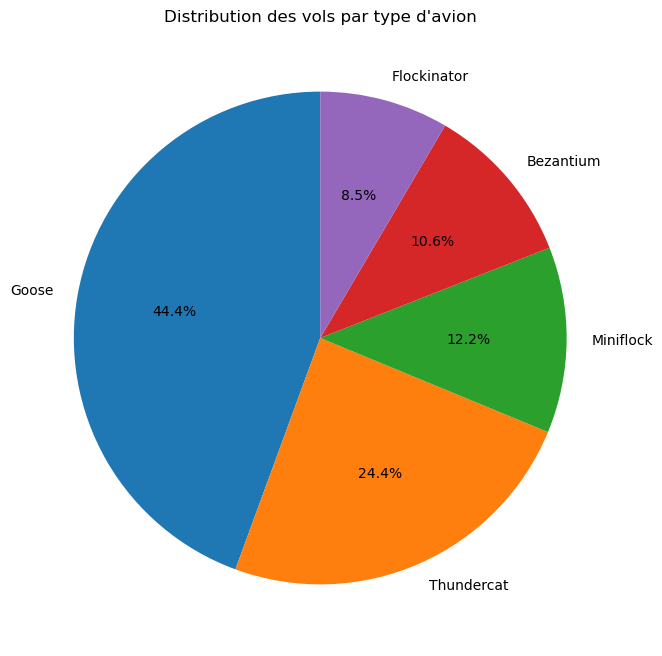

In [47]:
plt.figure(figsize=(10, 8))

plt.pie(
    sizes,
    labels=labels,
    autopct='%1.1f%%',
    startangle=90
)

plt.title('Distribution des vols par type d\'avion')

plt.show()

* L'appareil GOOSE assure la majorité des vols avec 44%

<Axes: xlabel='AIRCRAFT_TYPE', ylabel='NUMBER_OF_FLIGHTS'>

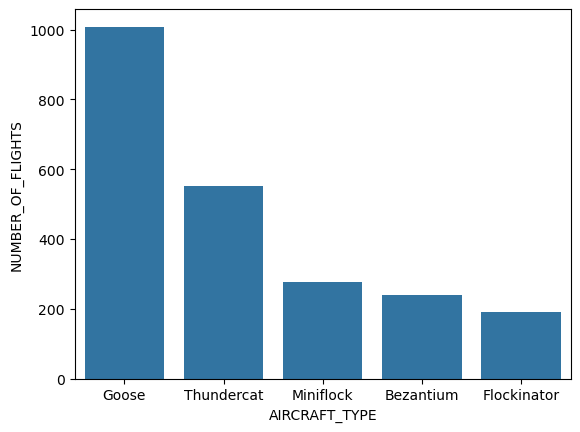

In [48]:
sns.barplot(data=fct_number_of_flights,
            x= "AIRCRAFT_TYPE",
            y= "NUMBER_OF_FLIGHTS")

## 2- Quel aéroport a été le plus emprunté par les passagers ?

* Import de la fct_airports

In [49]:
# Import de la fct_airports
fct_airports = fct_airports = conn.cursor().execute("SELECT * FROM fct_airports").fetch_pandas_all()
fct_airports.head()

,AIRPORT_CODE,AIRPORT_NAME,PASSENGERS_NB
0,FKT,Flocktopia,430959170.0
1,NSA,Nestland Airport,179064722.0
2,AMP,Amazon Mothership,80033991.0


In [50]:
# Création du graphique à barres
fig = px.bar(
    fct_airports,
    x="AIRPORT_NAME",
    y="PASSENGERS_NB",
    color="AIRPORT_NAME",       
    title='Aéroport ayant transporté le plus de passagers',
    labels={'passengers_nb': 'Sum of passengers_nb'} 
)

# Affichage des value labels
fig.update_traces(texttemplate='%{y}', textposition='outside')

fig.show(renderer="jupyterlab")

* L'aéroport FLOCKTOPIA à lui seul a accueilli plus de passagers que les 2 autres réunis 

## 3- Quelle a été la meilleure année en termes de recettes par psg/km pour chaque compagnie aérienne ? 

* Import de la fct_airlines

In [51]:
# Import de la fct_airlines
fct_airlines = fct_airlines = conn.cursor().execute("SELECT * FROM fct_airlines").fetch_pandas_all()
fct_airlines.head()

,AIRLINE_CODE,AIRLINE_NAME,YEAR,MAX_REVENUE,METRIQUE
0,AA,Amazon Airlines,2015,9175044.0,Revenu Domestique
1,FA,Flock Air,2016,13405774.0,Revenu Domestique
2,GA,Goose Airways,2016,34637841.0,Revenu Domestique
3,AA,Amazon Airlines,2016,2792855.0,Revenu International
4,FA,Flock Air,2016,3912894.0,Revenu International


In [52]:
fig = px.bar(
    fct_airlines,
    x= "AIRLINE_NAME",
    y= "MAX_REVENUE",
    color= "METRIQUE",
    barmode= 'group',
    text="YEAR"
)

fig.show(renderer="jupyterlab")

* Le revenu Domestique constitue pour chaque compagnie l'essentiel du revenu total.
* La meilleure année est 2015 pour Amazon Airlines, 2016 pour Flock_Air et Goose_Airways.

## 4- Quelle a été la meilleure année en termes de croissance pour chaque compagnie aérienne ? 


* Import de la fct_croissance_per_year

In [53]:
# Import de la fct_croissance_per_year
fct_croissance_per_year = fct_croissance_per_year = conn.cursor().execute("SELECT * FROM fct_croissance_per_year").fetch_pandas_all()
fct_croissance_per_year.head()

,AIRLINE_CODE,AIRLINE_NAME,YEAR,AVG_ASM_DOMESTIC,PREVIOUS_YEAR,TAUX_CROISSANCE
0,AA,Amazon Airlines,2002,315931.000000,NaN,NaN
1,AA,Amazon Airlines,2003,295645.527778,315931.000000,-6.42
2,AA,Amazon Airlines,2004,296641.388889,295645.527778,0.34
3,AA,Amazon Airlines,2005,255289.083333,296641.388889,-13.94
4,AA,Amazon Airlines,2006,270788.361111,255289.083333,6.07


### Evolution annuelle de l'ASM moyen par compagnie aérienne 

In [54]:
# Création du graphique en lignes
fig = px.line(
    fct_croissance_per_year,
    x="YEAR",                
    y="AVG_ASM_DOMESTIC",    
    color="AIRLINE_NAME",    
    title='Évolution annuelle de l\'ASM moyen par compagnie aérienne',
    labels={
        'avg_asm_domestic': 'avg_asm_domestic', 
        'year': 'year',
        'airline_name': 'airline_name'
    }
)

fig.show(renderer="jupyterlab")

* L'évolution de l'ASM moyen est assez stable pour Flock_Air et Amazon_Airlines.
* L'ASM moyen évolue de façon positive, bien que faiblement pour Goose_Airways.

### Evolution du taux de croissance annuel par compagnies aériennes 

In [55]:
# Création du graphique en lignes
fig = px.line(
    fct_croissance_per_year,
    x="YEAR",                
    y="TAUX_CROISSANCE",     
    color="AIRLINE_NAME",    
    title='Taux de croissance annuel par compagnies aériennes',
    labels={
        'taux_croissance': 'taux_croissance', 
        'year': 'year',
        'airline_name': 'airline_name'
    }
)

fig.show(renderer="jupyterlab")

* Le taux de croissance est faible et souvent négatif entre 2003 et 2009.
* Des pics soudain apparaissent à partir de 2010 avec :
* - Un taux de croissance de 20.67 pour Goose_Airways en 2010.
* - Un taux de croissance de 46.02 pour Amazon_Airlines en 2012.
* - Un taux de croissance de 16.04 pour Flock_Air en 2016.

### Année du meilleur taux de croissance 

* Import de la fct_croissance

In [56]:
# Import de la fct_croissance
fct_croissance = fct_croissance = conn.cursor().execute("SELECT * FROM fct_croissance").fetch_pandas_all()
fct_croissance.head()

,AIRLINE_CODE,AIRLINE_NAME,BEST_YEAR,BEST_TAUX_CROISSANCE
0,AA,Amazon Airlines,2012,46.02
1,FA,Flock Air,2016,16.04
2,GA,Goose Airways,2010,20.67


In [57]:
# Création du graphique à barres
fct_croissance['BEST_YEAR'] = fct_croissance['BEST_YEAR'].astype(str)

fig = px.bar(
    fct_croissance,
    x="AIRLINE_NAME",              
    y="BEST_TAUX_CROISSANCE",      
    color="BEST_YEAR",            
    title='Année du taux de croissance le plus élevé',
    labels={
        'best_taux_croissance': 'best_taux_croissance', 
        'airline_name': 'airline_name',
        'best_year': 'best_year'
    }
)

fig.show(renderer="jupyterlab")

* Les années où le taux de croissance est le plus élevé sont bien celles du précédent graphique.

## Données en .CSV

In [58]:
#Téléchargement des tables facts en .csv avant la fin de la période d'essai sur SNOWFLAKE et DBT
fct_croissance.to_csv("fct_croissance.csv",index=False)
fct_airlines.to_csv("fct_airlines.csv",index=False)
fct_airports.to_csv("fct_airports.csv",index=False)
fct_croissance_per_year.to_csv("fct_croissance_per_year.csv",index=False)
fct_number_of_flights.to_csv("fct_number_of_flights.csv",index=False)

In [59]:
#Téléchargement des tables dimensions en .csv avant la fin de la période d'essai sur SNOWFLAKE et DBT 
dim_aircraft.to_csv("dim_aircraft.csv",index=False)
dim_airlines.to_csv("dim_airlines.csv",index=False)
dim_airports.to_csv("dim_airports.csv",index=False)
dim_flight_summary_data.to_csv("dim_flight_summary_data.csv",index=False)
dim_individual_flights.to_csv("dim_individual_flights.csv",index=False)

In [60]:
#Téléchargement des staging en .csv avant la fin de la période d'essai sur SNOWFLAKE et DBT
stg_aircraft.to_csv("stg_aircraft.csv",index=False)
stg_airlines.to_csv("stg_airlines.csv",index=False)
stg_airports.to_csv("stg_airports.csv",index=False)
stg_flight_summary_data.to_csv("stg_flight_summary_data.csv",index=False)
stg_individual_flights.to_csv("stg_individual_flights.csv",index=False)